In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from category_encoders import MEstimateEncoder
import sklearn
sklearn.set_config(transform_output="pandas")
from scipy import stats
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from xgboost import XGBRegressor

In [2]:
%%capture

%run cleaning_marc_final.ipynb ;

# 3.  Predictions : TotalGHGEmissions

In [26]:
# removing \n chars from a copy paste
possible_features = ['floor_building', 'is_campus ',' p_gas ',' p_elec ',' p_steam ',' WN_ratio ',' Data_Center ',' Other ',' Hotel ',' SupermarketGrocery_Store ',' Medical_Office ',' Other___Recreation ',' Senior_Care_Community ',' Laboratory ',' Hospital_General_Medical_and_Surgical']
i = 0
while i < len(possible_features):
    possible_features[i] = possible_features[i].strip()
    i+=1

In [19]:

# not used anymore but for legacy : features = ['NumberofBuildings' , 'NumberofFloors' , 'is_laboratory' , 'is_hospital' , 'p_gas' , 'p_steam' , 'PropertyGFABuildings' , 'LargestPropertyUseType_SupermarketGrocery_Store' , 'LargestPropertyUseType_Senior_Care_Community' ,'LargestPropertyUseType_Data_Center' , 'LargestPropertyUseType_Hotel']
# a corriger
X_GHG = ols_df[possible_features].to_numpy()
y_GHG = ols_df['TotalGHGEmissions'].to_numpy()
X_train_GHG, X_test_GHG , y_train_GHG, y_test_GHG = train_test_split(X_GHG,y_GHG,test_size=0.2, random_state=33)

In [31]:
rf = RandomForestRegressor()
param_rf = {'n_estimators':[i for i in range(1,20,1)],
           'max_depth':[i for i in range(1,10,1)],
           'max_leaf_nodes':[i for i in range(1,10)]}
regr = GridSearchCV(rf,param_grid=param_rf,scoring='r2',cv=5,refit=True)
regr.fit(X_train_GHG,y_train_GHG)

C:\Users\Utilisateur\anaconda3\envs\myenv\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
855 fits failed out of a total of 7695.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
855 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Utilisateur\anaconda3\envs\myenv\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Utilisateur\anaconda3\envs\myenv\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\Utilisateur\anaconda3\envs\myenv\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_pa

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'max_leaf_nodes': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15, 16, 17, 18, 19]},
             scoring='r2')

In [32]:
regr.score(X_train_GHG,y_train_GHG)

0.8726015275832654

In [33]:
params = regr.best_params_
params

{'max_depth': 5, 'max_leaf_nodes': 8, 'n_estimators': 4}

In [34]:
final_rf = RandomForestRegressor(n_estimators = params['n_estimators'],max_depth=params['max_depth'])
final_rf.fit(X_train_GHG,y_train_GHG)
metrics.r2_score(y_test_GHG,final_rf.predict(X_test_GHG))

0.8919851631117947

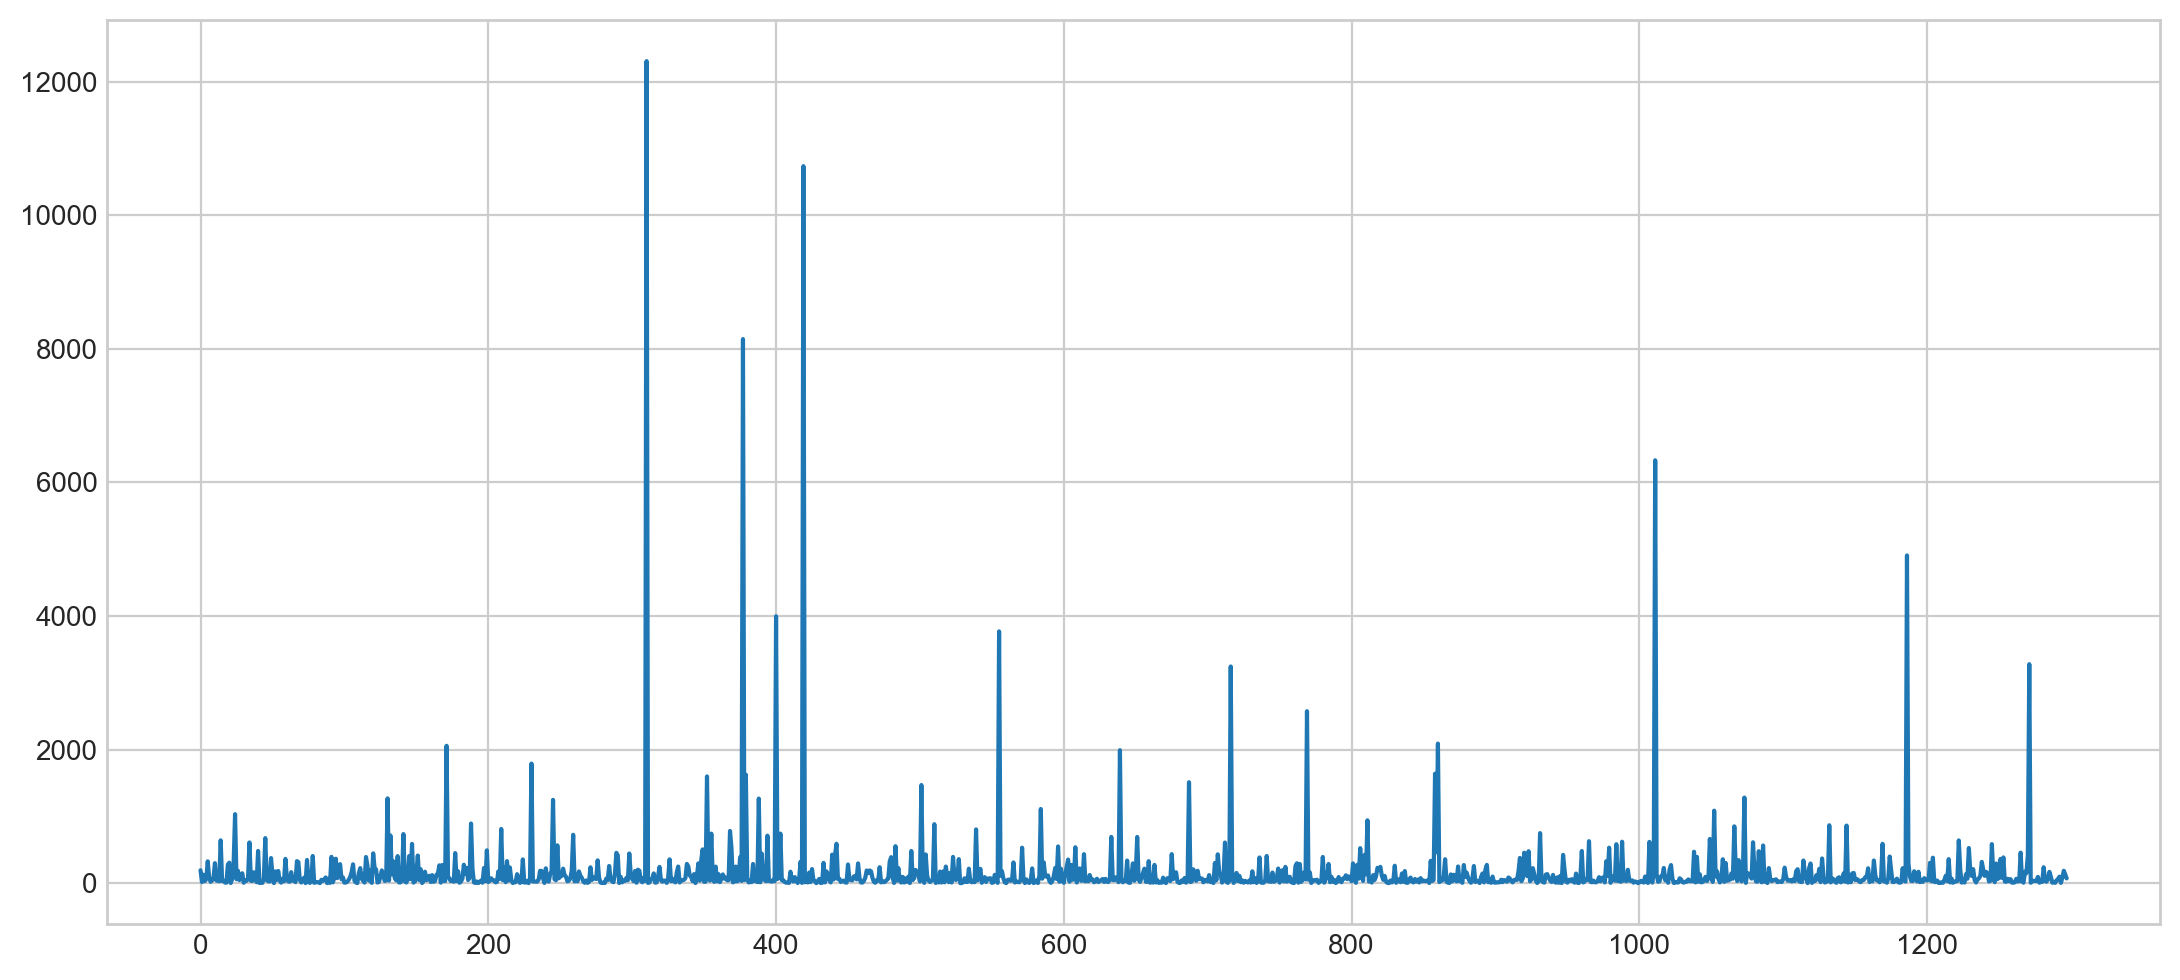

In [11]:
plt.plot(y_train_GHG)

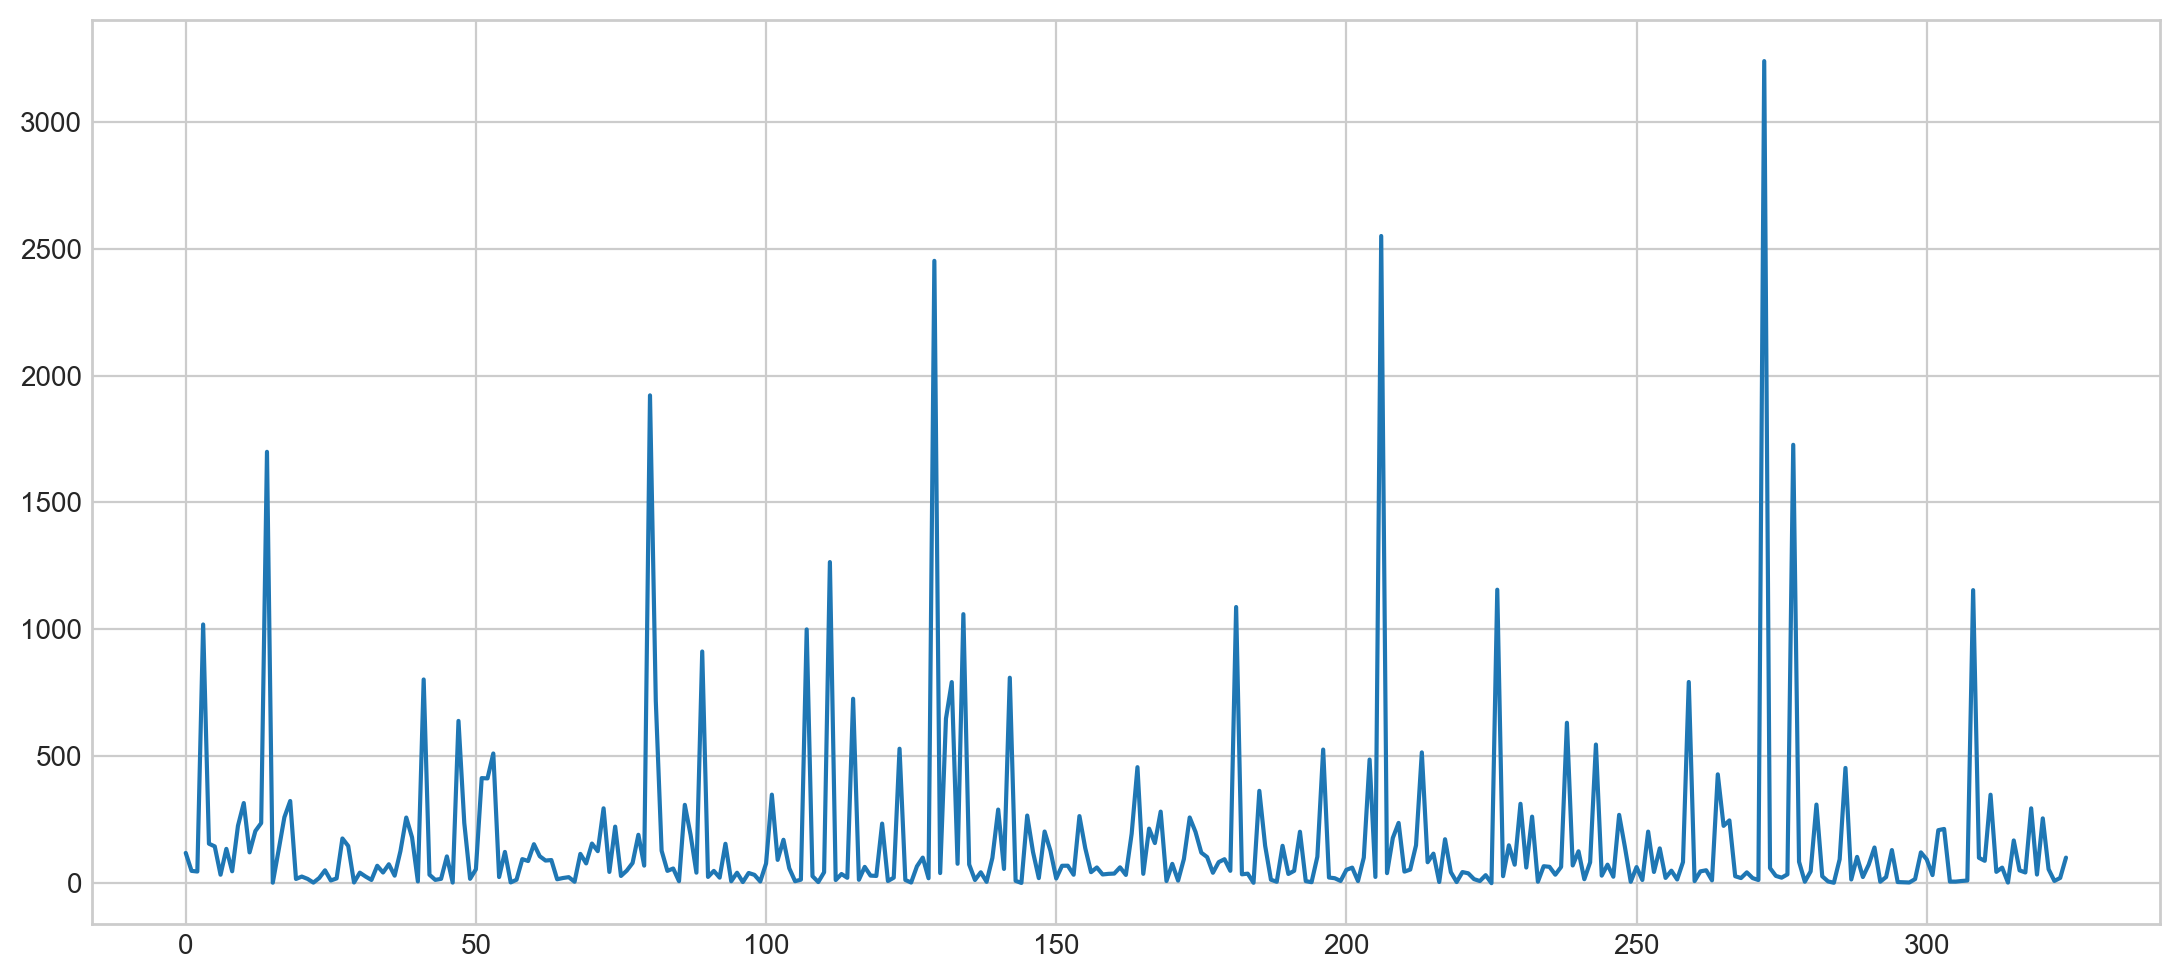

In [12]:
plt.plot(y_test_GHG)

# 4.  Prediction : SiteEnergyUsekBtu

In [180]:
possible_features_E = ['Neighborhood_northeast','floor_building',' is_campus ',' Data_Center ',' Office ',' Non_Refrigerated_Warehouse ',' K_12_School ',' Retail_Store ',' Other ',' Hotel ',' Distribution_Center ',' SupermarketGrocery_Store ',' Medical_Office ',' Other___Recreation ',' CollegeUniversity ',' Other___EntertainmentPublic_Assembly ',' Senior_Care_Community ',' Laboratory ',' Restaurant ',' Refrigerated_Warehouse ',' SocialMeeting_Hall ',' Hospital_General_Medical_and_Surgical ',' Multifamily_Housing ',' Strip_Mall' ]
i = 0 # ' decennie ',
while i < len(possible_features_E):
    possible_features_E[i] = possible_features_E[i].strip()
    i+=1

In [181]:
#features = ['WN_ratio', 'YearBuilt' ,'NumberofBuildings', 'is_laboratory','LargestPropertyUseType_Hospital_General_Medical_and_Surgical', 'is_campus' , 'PropertyGFABuildings' , 'LargestPropertyUseType_SupermarketGrocery_Store','LargestPropertyUseType_Data_Center' , 'LargestPropertyUseType_Hotel']
# a corriger
X_energy = ols_df[possible_features_E]
y_energy = ols_df['SiteEnergyUseWNkBtu']

## 4.0 ACP

In [113]:
from IPython.display import display
from sklearn.feature_selection import mutual_info_regression



plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs



def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


In [114]:
X_scaled = (X_energy - X_energy.mean(axis=0)) / X_energy.std(axis=0)

In [115]:
from sklearn.decomposition import PCA

# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(1,X_pca.shape[1])]
X_pca_df = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,...,pca14,pca15,pca16,pca17,pca18,pca19,pca20,pca21,pca22,pca23
0,0.025284,-0.058607,-0.357789,-0.227960,1.321192,0.141641,0.182009,-0.117189,-0.188396,0.126189,...,-0.061111,-0.073915,0.133391,-1.022008,-0.218316,-0.218651,0.629796,0.005980,0.139621,-0.026100
1,0.164749,-0.161278,-0.298373,0.418089,1.471935,0.202506,0.279224,-0.270458,-0.263434,0.122211,...,-0.095794,-0.163070,-0.181680,-1.111616,-0.322534,0.177934,-0.070323,-0.064115,0.108524,-0.003921
2,5.421513,-0.105647,-1.273596,-1.952629,10.760700,3.154593,1.886032,-0.566810,-2.087651,1.090903,...,-0.075382,-0.446591,0.801635,-7.182767,-3.987023,1.054180,7.024240,0.111903,-0.749002,0.998055
3,-0.104640,-0.051992,-0.316317,-0.176397,0.933254,0.025561,0.113998,-0.100952,-0.111898,0.086772,...,-0.057313,-0.054595,0.101559,-0.770321,-0.073994,-0.261726,0.382818,0.004087,0.169677,0.023221
4,0.238576,-0.064744,-0.409140,-0.303962,1.819653,0.294700,0.270415,-0.139184,-0.287473,0.176951,...,-0.064370,-0.096719,0.172087,-1.346159,-0.409085,-0.158643,0.955119,0.009654,0.097740,-0.043338


In [69]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X_energy.columns,  # and the rows are the original features
)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24
Neighborhood_northeast,-0.086470,-0.094659,-0.044482,-0.091057,-0.244985,0.585782,0.067361,0.141852,-0.091830,0.107297,...,0.151231,0.019288,0.019298,0.181674,-0.659461,-0.120837,-0.120866,0.033923,-0.026290,-0.022671
floor_building,0.680542,0.035952,0.032866,-0.140823,-0.036854,0.047394,0.008776,-0.015360,-0.004474,-0.002006,...,0.024586,0.032046,-0.035982,0.012567,-0.065966,0.065574,0.095859,0.018381,-0.045911,0.694282
is_campus,-0.033329,-0.378590,0.587173,-0.089503,0.020565,0.004041,0.000251,0.008721,0.001676,-0.003442,...,-0.000988,-0.004819,-0.007675,0.055397,-0.008568,0.012096,0.097957,-0.692136,-0.101043,0.002449
Data_Center,0.066494,0.005357,-0.024013,-0.095909,-0.126901,-0.037477,-0.078671,-0.061141,0.113745,0.055253,...,0.044611,-0.051977,0.049190,0.090630,-0.005782,0.148877,0.047410,0.002390,-0.025875,-0.009779
Office,0.654535,0.074927,0.028262,-0.131983,-0.242276,-0.027383,-0.047443,-0.001330,0.038826,-0.020389,...,-0.032120,0.007293,-0.024382,-0.033712,-0.006519,-0.019807,-0.086800,-0.058465,0.017161,-0.677026
Non_Refrigerated_Warehouse,-0.065409,0.593580,0.348868,0.029634,0.001925,0.092555,0.021753,0.045207,-0.043685,-0.066693,...,-0.017030,-0.001944,0.003519,-0.017500,0.017719,-0.036933,-0.031525,0.067206,-0.700431,-0.018750
K_12_School,-0.088381,-0.073439,-0.078307,-0.193322,-0.134606,0.172150,-0.215984,-0.392270,-0.543913,-0.268832,...,-0.066436,-0.012902,-0.076208,0.153218,0.094008,0.473111,0.170988,0.052262,-0.086093,-0.053296
Retail_Store,0.053712,-0.014375,0.024518,0.371875,-0.127353,0.108323,-0.244522,0.319431,0.041193,-0.039225,...,-0.085857,0.001829,0.712329,-0.065425,0.021688,0.346717,0.109254,-0.014816,0.015055,0.009486
Other,0.139292,-0.163867,0.154746,0.575207,-0.031276,0.036316,0.035184,-0.012444,-0.111333,0.070249,...,0.060447,0.004033,-0.223881,0.380933,0.067682,-0.222254,0.503003,0.243269,-0.040266,-0.091405
Hotel,0.127627,-0.016151,-0.074930,-0.068323,0.663922,0.190674,0.114312,-0.025478,-0.129314,0.067221,...,-0.009811,-0.037196,0.058983,-0.429190,-0.236102,0.064195,0.406368,0.000702,-0.044771,-0.178685


array([<Axes: title={'center': '% Explained Variance'}, xlabel='Component'>,
       <Axes: title={'center': '% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

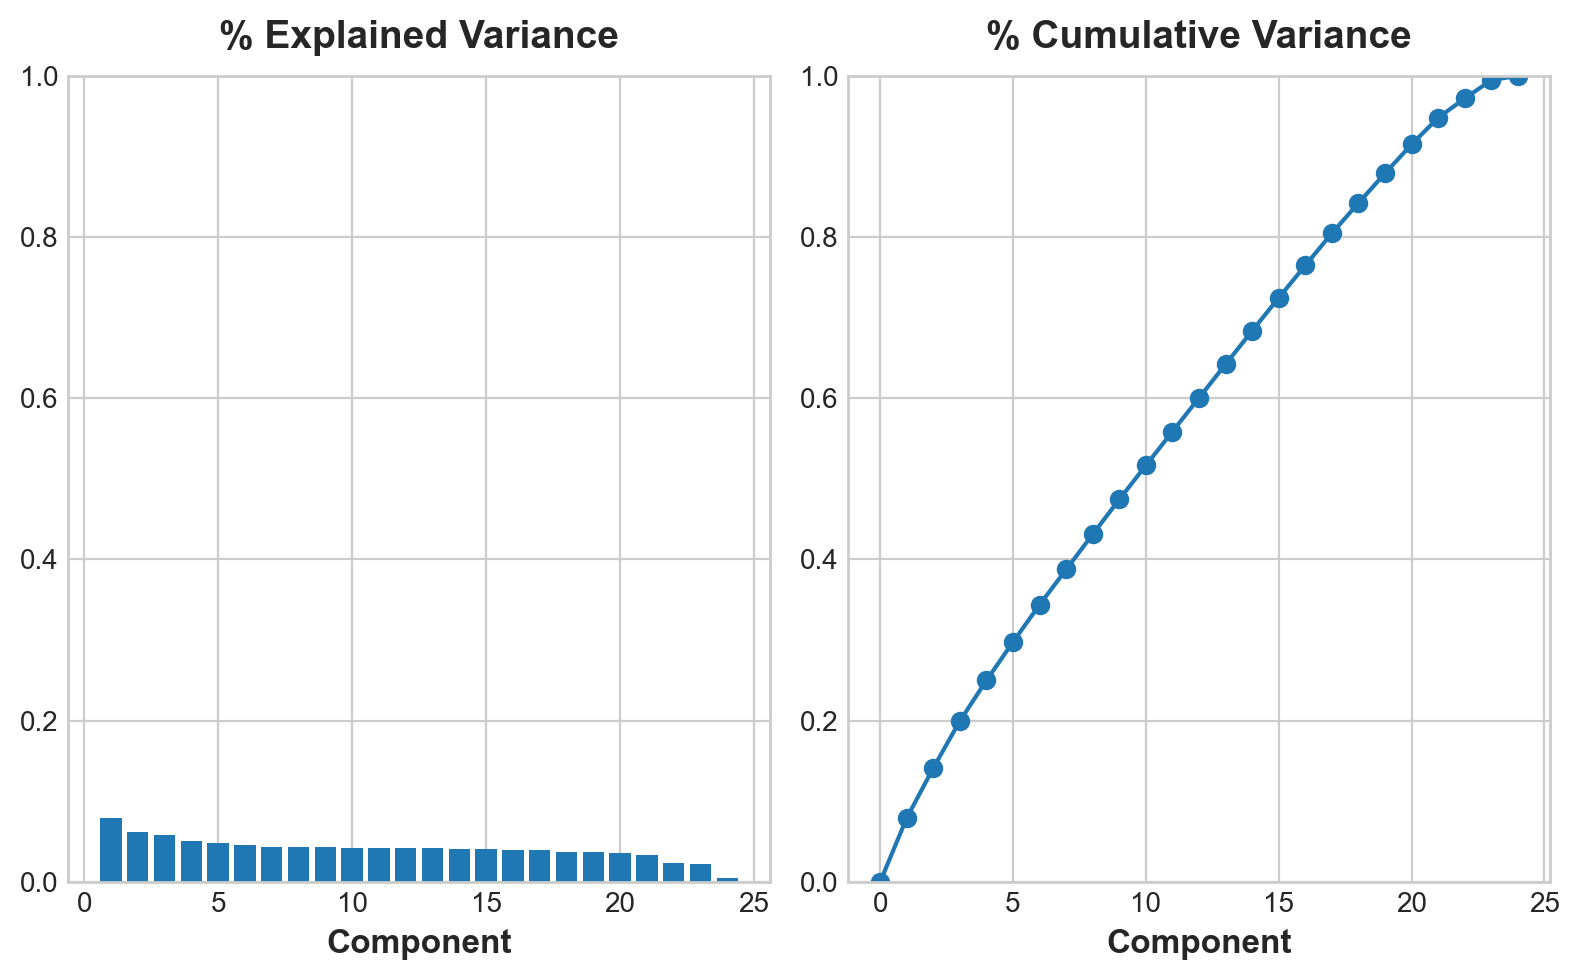

In [65]:
plot_variance(pca)

In [91]:
mi_scores = make_mi_scores(X_pca, y_energy, discrete_features=False)
mi_scores

pca0     0.328972
pca3     0.324775
pca4     0.323542
pca15    0.322326
pca13    0.318862
pca6     0.285378
pca23    0.278661
pca21    0.276149
pca8     0.275585
pca10    0.256726
pca16    0.254750
pca18    0.245644
pca7     0.235246
pca1     0.232849
pca9     0.226415
pca5     0.226236
pca19    0.222675
pca2     0.211506
pca20    0.208782
pca17    0.203439
pca14    0.164192
pca12    0.152027
pca11    0.146021
pca22    0.110548
Name: MI Scores, dtype: float64

In [110]:
loadings.PC14

Neighborhood_northeast                   0.003476
floor_building                          -0.069813
is_campus                                0.000495
Data_Center                              0.927733
Office                                  -0.100464
Non_Refrigerated_Warehouse               0.025586
K_12_School                             -0.092160
Retail_Store                            -0.064805
Other                                    0.044863
Hotel                                    0.099801
Distribution_Center                     -0.198397
SupermarketGrocery_Store                -0.066424
Medical_Office                           0.054219
Other___Recreation                      -0.056822
CollegeUniversity                       -0.010310
Other___EntertainmentPublic_Assembly    -0.063904
Senior_Care_Community                    0.119714
Laboratory                              -0.039927
Restaurant                               0.078700
Refrigerated_Warehouse                   0.023367


In [190]:
# ajout de pca14 à X_energy
X_energy['PC0'] =X_pca['pca0'].values
X_energy['PC3'] =X_pca['pca3'].values
X_energy['PC14'] =X_pca['pca13'].values
X_energy.drop(columns=['Data_Center'], inplace =True)

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_9144\570283898.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_energy['PC0'] =X_pca['pca0'].values
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_9144\570283898.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_energy['PC3'] =X_pca['pca3'].values
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_9144\570283898.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [176]:
X_energy.columns

Index(['Neighborhood_northeast', 'floor_building', 'is_campus', 'Office',
       'Non_Refrigerated_Warehouse', 'K_12_School', 'Retail_Store', 'Other',
       'Hotel', 'Distribution_Center', 'SupermarketGrocery_Store',
       'Medical_Office', 'Other___Recreation', 'CollegeUniversity',
       'Other___EntertainmentPublic_Assembly', 'Senior_Care_Community',
       'Laboratory', 'Restaurant', 'Refrigerated_Warehouse',
       'SocialMeeting_Hall', 'Hospital_General_Medical_and_Surgical',
       'Multifamily_Housing', 'Strip_Mall', 'PC14', 'PC0', 'PC3'],
      dtype='object')

## 4.1 train test séparation

In [183]:
X_train_energy, X_test_energy , y_train_energy, y_test_energy = train_test_split(X_energy,y_energy,test_size=0.2, random_state=42)

## 4.2 target encoding ??

In [184]:
from category_encoders import MEstimateEncoder

# Create the encoder instance. Choose m to control noise.
encoder = MEstimateEncoder(cols=["Neighborhood_northeast"], m=5.0)

# Fit the encoder on the encoding split.
encoder.fit(X_train_energy, y_train_energy)

# Encode the Zipcode column to create the final training data
X_train_energy_encoded = encoder.transform(X_train_energy)
X_test_energy_encoded = encoder.transform(X_test_energy)

## 4.3 model et predictions

In [185]:
#rf = RandomForestRegressor()
#param_rf = {'n_estimators':[i for i in range(1,20,1)],
#           'max_depth':[i for i in range(1,10,1)],
#           'max_leaf_nodes':[i for i in range(1,10)]}
#regr = GridSearchCV(rf,param_grid=param_rf,scoring='r2',cv=5,refit=True)
#regr.fit(X_train_energy,y_train_energy)

In [188]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train_energy)
X_test_scaled = sc.transform(X_test_energy)

lr = LinearRegression()
param_lr={
    
}
lr = GridSearchCV(lr,param_grid=param_lr,scoring='r2',cv=5,refit=True)
lr.fit(X_train_scaled,y_train_energy)
lr.score(X_train_scaled,y_train_energy)
params = lr.best_params_

In [189]:
final_lr = LinearRegression()
final_lr.fit(X_train_scaled,y_train_energy)
metrics.r2_score(y_test_energy,final_lr.predict(X_test_scaled))

0.6691332787923837

In [26]:
# rs = 12 : 0.7164 ( sans target & pca14); 0.73 avec (NumberofBuildings encoded)
# rs = 20 : 0.36 ( "decennie + nbr buildings") , 0.41
# rs = 42 : 0.57( sans target & pca14), 0.62(pca14), 0.632(target + pca 14)

In [137]:
#params = regr.best_params_
#regr.score(X_train_energy,y_train_energy)

0.8558700214558322

In [149]:
#final_rf = RandomForestRegressor(n_estimators = params['n_estimators'],max_depth=params['max_depth'])
#final_rf.fit(X_train_energy,y_train_energy)
#metrics.r2_score(y_test_energy,final_rf.predict(X_test_energy))

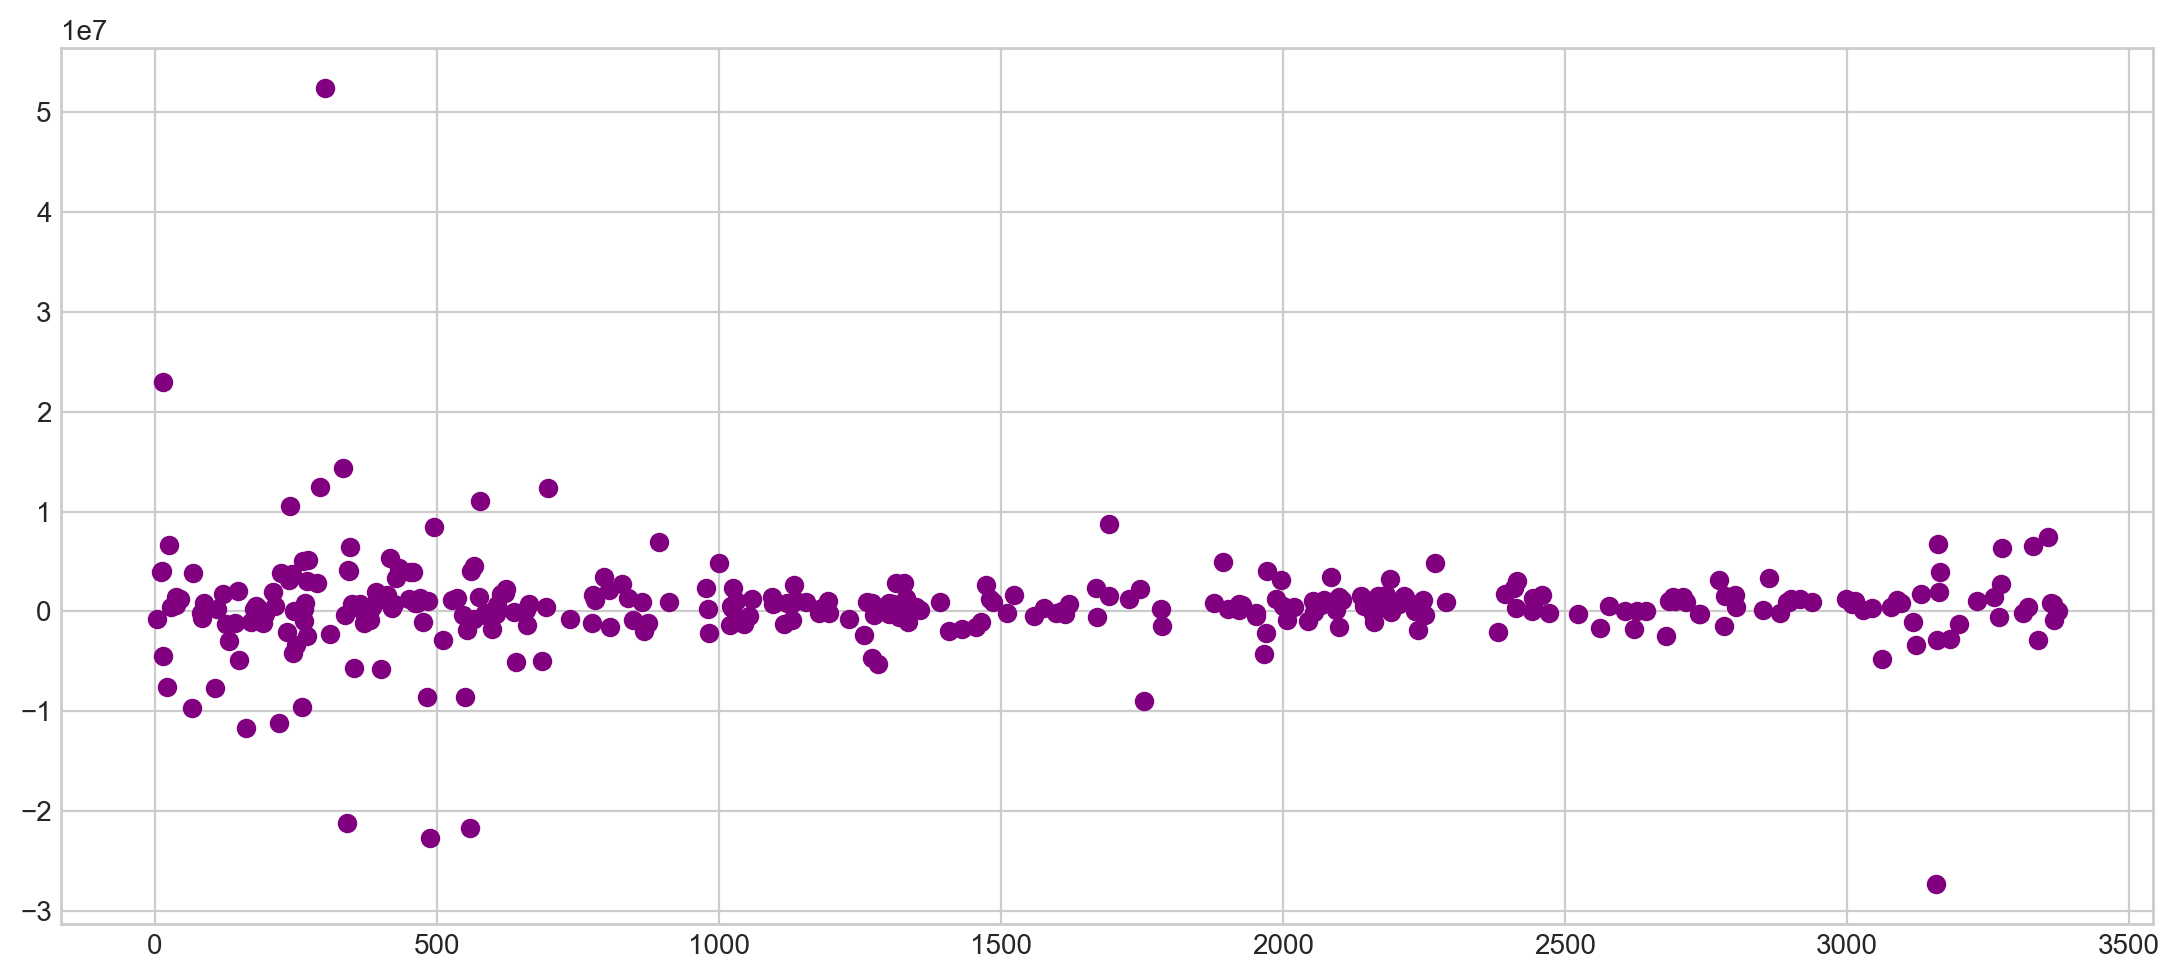

In [152]:
res_energy = pd.DataFrame(y_test_energy)
res_energy['preds'] = final_lr.predict(X_test_energy)
res_energy['diff'] = res_energy.apply(lambda x : x['preds'] - x['SiteEnergyUseWNkBtu'] , axis =1 )
plt.scatter(x = res_energy.index,y = res_energy['diff'], color='purple')